In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score,precision_score,recall_score,f1_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans  
from imblearn.under_sampling import ClusterCentroids



In [49]:
import random
random.seed(42)


## Part A: Data Exploration and Baseline Model

### 1. Load and Analyze the Dataset

In [50]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Analyze Class Distribution

1 in case of fraud and 0 otherwise.



In [5]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

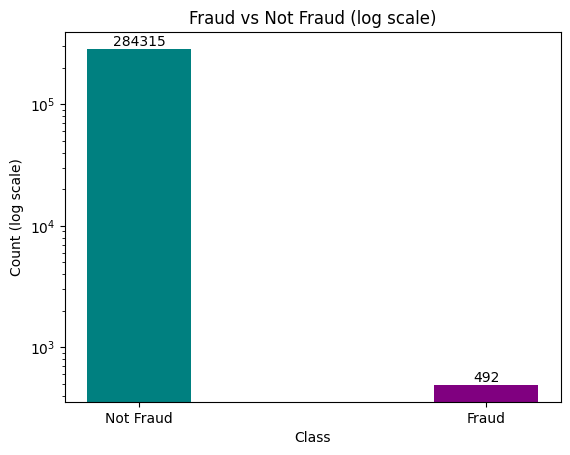

In [6]:
counts = df['Class'].value_counts()
plt.bar(counts.index,counts.values,width=0.3,color = ['teal','purple'])
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Count (log scale)")
plt.yscale("log")   
plt.title("Fraud vs Not Fraud (log scale)")

for i,val in enumerate(counts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.show()

In [51]:
def class_imbalance(counts):
    no_of_frauds = counts[1]
    no_of_legit = counts[0]

    percent_fraud = (no_of_frauds/(no_of_frauds + no_of_legit))*100
    print(f"The percentage of fradulent activities happen is {percent_fraud:.2f}")

class_imbalance(counts)

The percentage of fradulent activities happen is 0.17


#### 2.1 Data Splitting

Setting stratify parameter to y to nsure the test dataset retains its original imbalance. 

In [8]:
X = df.drop(columns=['Class','Time','Amount'])
y = df['Class']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

#### 2.2 Checking Class imbalance

In [9]:
print(y_train.value_counts())
train_val = y_train.value_counts()
class_imbalance(train_val)

Class
0    227451
1       394
Name: count, dtype: int64
The percentage of fradulent activities happen is 0.173


In [10]:
print(y_test.value_counts())
class_imbalance(y_test.value_counts())

Class
0    56864
1       98
Name: count, dtype: int64
The percentage of fradulent activities happen is 0.172


### 3. Baseline Model

In [11]:
imbalanced_model = LogisticRegression(random_state=42)
imbalanced_model.fit(x_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [57]:
y_pred = imbalanced_model.predict(x_test)

acc_score = accuracy_score(y_test,y_pred)
prec_score = precision_score(y_test,y_pred)
rec_score = recall_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)

print(f"Accuracy of the imbalanced model is {acc_score:.2f}")
print(f"Precision of the imbalanced model is {prec_score:.2f}")
print(f"Recall of the imbalanced model is {rec_score:.2f}")
print(f"F1 Score of the imbalanced model is {f1:.2f}")

Accuracy of the imbalanced model is 1.00
Precision of the imbalanced model is 0.83
Recall of the imbalanced model is 0.64
F1 Score of the imbalanced model is 0.72


## Part B: Gaussian Mixture Model (GMM) for Synthetic Sampling

### 1.​ Theoretical Foundation

#### SMOTE vs GMM

**How SMOTE Generates new samples**
- First after it consider a point in **minority class** and find it neighbours using **KNN** algo.

- Then it a generates a new point along the line joining the point and its neighbour 

**How GMM Generates new samples**
- GMM's assume that the **minority class** data  can be represented by a mixture of several Gaussian distributions.

- So it first initializes the parameters: means, covariances, and mixture weights for each Gaussian component.

- And then:
    - It calculates the **probability** that each data point belongs to each Gaussian component.

    - And it update the parameters (means, covariances, and weights) to better fit the data

- The above process is repeated until the parameters wont change.

- So after convergence, GMM has learned a probabilistic model of the minority class.

- No, new samples can be generated by sampling from these Gaussian components according to their mixture weights. This ensures that **synthetic points** follow the same distribution as the original data.


**Difference between SMOTE And GMM**

- SMOTE tries to generate the synthetic smaples by picking a point on straight line this is simple and effective but it is not understanding the underlying distribution of data which can lead to generation of noisy data or generation of similiar points over and and over again.

- On other hand GMM first tries to analyze the undrelying pattern of data so that synthetic data better reflects the underlying probability density of the minority class rather than just interpolating between points.

- So the fundemental difference between GMM and others is instead of just generating synthetic data it tries to unsderstand underlying pattern and generates accordingly

**Why GMM is theoretically better**

- SMOTE assume that whole minority class is a single cluster but it may contain multiple sub groups inside so when while generating the synthetic data assuming as single group the point generated couldnt able to represent other group which lead to **addition of noise** in the cluster 

- Or the new point created is already repersented by another so model when training on same data over and over again can lead to **overfitting**

- Unlike this GMM assume the data is as a mixture of several Gaussian distributions and tries to find weight of each guassian distribution according to above process.

- How does this benifits us? Well take previous scenario assume data has multiple subgroups but unlike previous case now we have probabilty distribution that represents each subgroup.

- Now while generating the synthetic data using those distribution the data has close resembalance to original data as it follow same distribution of original data

- Hence there is lesser chance of generation of noisy samples and overfitting

- So in conclusion, GMM captures underlying distribution of data which is much robust than simple algorithms like SMOTE when data has mutliple subgroups or has complex patterns

### 2.​ GMM Implementation

In [13]:
x_minority = x_train[y_train==1]
x_majority = x_train[y_train==0]
x_minority.shape

(394, 28)

#### 2.1 Akaike Information Criterion (AIC) to determine k

In [14]:
aic_values = []
bic_values = []

for k in range(1,11):
    gmm = GaussianMixture(n_components=k,random_state=42)
    gmm.fit(x_minority)
    aic_values.append(gmm.aic(x_minority))
    bic_values.append(gmm.bic(x_minority))

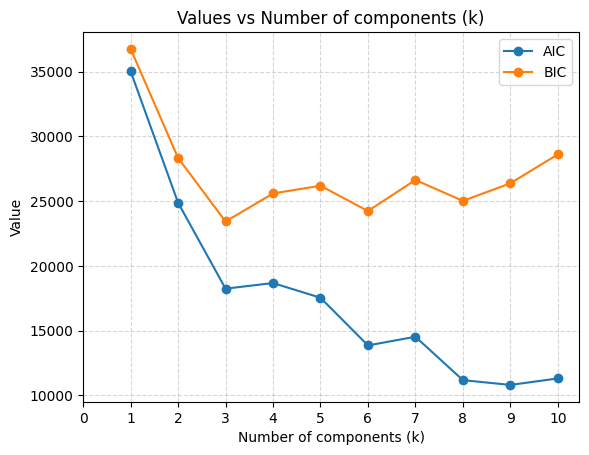

In [15]:
plt.plot(range(1,11), aic_values, marker='o',label='AIC')
plt.plot(range(1,11), bic_values, marker='o',label='BIC')
plt.legend()

plt.xticks(ticks=range(0,11))
plt.xlabel("Number of components (k)")
plt.ylabel("Value")
plt.grid(True,linestyle='--',alpha=0.5)
plt.title("Values vs Number of components (k)")
plt.show()



#### I can see a dip of  both aic and bic values at 3 so considering of  components as 3

### 3.​ Synthetic Data Generation

In [16]:
gmm = GaussianMixture(n_components=3,random_state=42)
gmm.fit(x_minority)
num_samples = train_val[0] - train_val[1]
x_synthetic, _ = gmm.sample(num_samples)

x_synthetic = pd.DataFrame(x_synthetic,columns=x_minority.columns)
x_synthetic['class'] = 1


In [17]:
x_synthetic.shape

(227057, 29)

In [18]:
x_gmm_resampled = pd.concat([x_train,x_synthetic],ignore_index=True)
x_gmm_resampled.drop(columns=['class'],inplace=True)
y_gmm_resampled = pd.concat([y_train,x_synthetic['class']],ignore_index=True)


In [19]:
x_gmm_resampled.shape

(454902, 28)

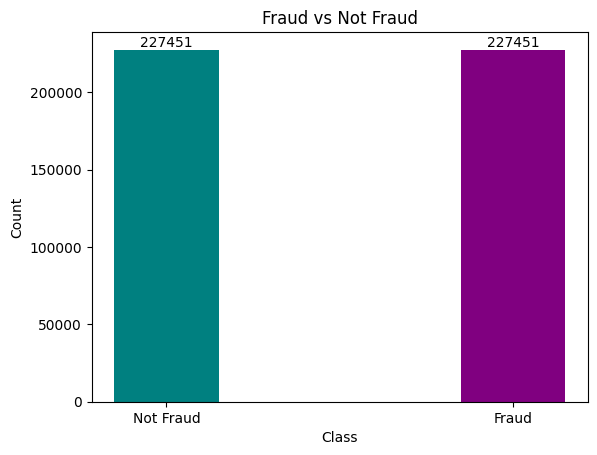

In [20]:
cnts = y_gmm_resampled.value_counts()
plt.bar(cnts.index,cnts.values,width=0.3,color = ['teal','purple'])
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Fraud vs Not Fraud")

for i,val in enumerate(cnts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.show()

In [21]:
class_imbalance(cnts)

The percentage of fradulent activities happen is 50.000


### 4. Rebalancing with CBU

##### Elbow Method For Optimal k

Text(0.5, 1.0, 'Elbow Method for Optimal k')

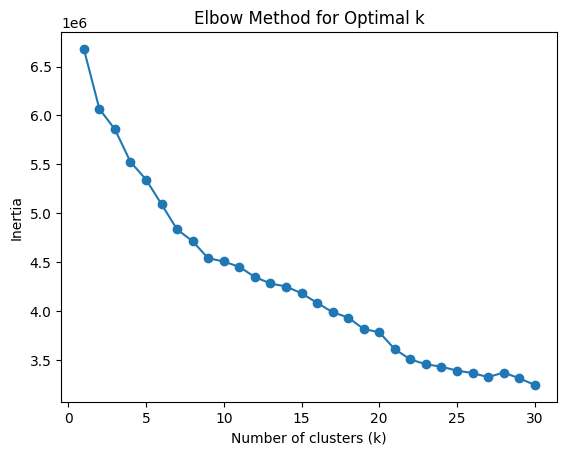

In [22]:
X_majority_class = x_train[y_train == 0]
inertia = []
for k in range(1, 31):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_majority_class)
    ina = kmeans.inertia_
    inertia.append(ina)
plt.plot(range(1, 31), inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')



In [23]:
kmeans = KMeans(n_clusters=20, random_state=42)


In [24]:
cbu = ClusterCentroids(random_state=42,estimator=kmeans,sampling_strategy={0:10000})
x_resampled, y_resampled = cbu.fit_resample(x_train, y_train)


In [25]:
resampled_cnt = y_resampled.value_counts()

In [26]:
num_samples = resampled_cnt[0] - resampled_cnt[1]
gmm = GaussianMixture(n_components=3,random_state=42)
gmm.fit(x_minority)
x_synthetic, _ = gmm.sample(num_samples)


In [27]:
x_synthetic = pd.DataFrame(x_synthetic,columns=x_minority.columns)
x_resampled_cbu_gmm = pd.concat([x_resampled,x_synthetic],ignore_index=True)
y_resampled_cbu_gmm = pd.Series(y_resampled.tolist() + [1]*num_samples)

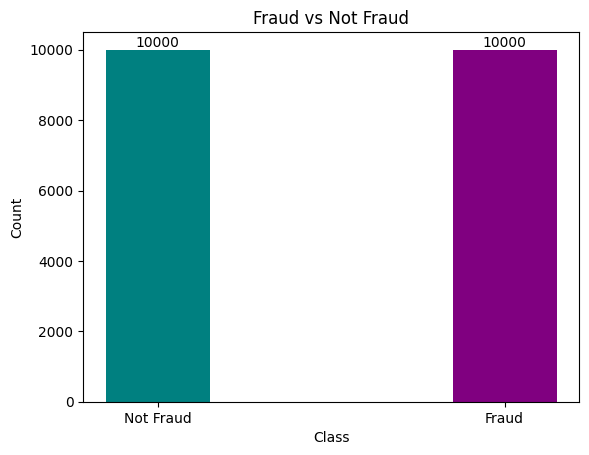

In [28]:
cnts = y_resampled_cbu_gmm.value_counts()
plt.bar(cnts.index,cnts.values,width=0.3,color = ['teal','purple'])
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Fraud vs Not Fraud")

for i,val in enumerate(cnts.values):
    plt.text(i, val, str(val), ha='center', va='bottom')

plt.show()

## Part C: Performance Evaluation and Conclusion

### 1.​ Model Training and Evaluation 

In [29]:
gmm_model = LogisticRegression(random_state=42)
gmm_model.fit(x_gmm_resampled,y_gmm_resampled)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [43]:
y_pred_gmm = gmm_model.predict(x_test)
acc_score_gmm = accuracy_score(y_test,y_pred_gmm)
prec_score_gmm = precision_score(y_test,y_pred_gmm)
rec_score_gmm = recall_score(y_test,y_pred_gmm)
f1_gmm = f1_score(y_test,y_pred_gmm)

print(f"Accuracy of the GMM model is {acc_score_gmm:.2f}")
print(f"Precision of the GMM model is {prec_score_gmm:.2f}")
print(f"Recall of the GMM model is {rec_score_gmm:.2f}")
print(f"F1 Score of the GMM model is {f1_gmm:.2f}")

Accuracy of the GMM model is 0.98
Precision of the GMM model is 0.08
Recall of the GMM model is 0.89
F1 Score of the GMM model is 0.14


In [44]:
cbu_gmm_model = LogisticRegression(random_state=42)
cbu_gmm_model.fit(x_resampled_cbu_gmm,y_resampled_cbu_gmm)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [45]:
y_pred_cbu_gmm = cbu_gmm_model.predict(x_test)
acc_score_cbu_gmm = accuracy_score(y_test,y_pred_cbu_gmm)
prec_score_cbu_gmm = precision_score(y_test,y_pred_cbu_gmm)
rec_score_cbu_gmm = recall_score(y_test,y_pred_cbu_gmm)
f1_cbu_gmm = f1_score(y_test,y_pred_cbu_gmm)

print(f"Accuracy of the CBU + GMM model is {acc_score_cbu_gmm:.2f}")
print(f"Precision of the CBU + GMM model is {prec_score_cbu_gmm:.2f}")
print(f"Recall of the CBU + GMM model is {rec_score_cbu_gmm:.2f}")
print(f"F1 Score of the CBU + GMM model is {f1_cbu_gmm:.2f}")


Accuracy of the CBU + GMM model is 0.97
Precision of the CBU + GMM model is 0.05
Recall of the CBU + GMM model is 0.89
F1 Score of the CBU + GMM model is 0.10


### 2.​ Comparative Analysis

In [ ]:
### SMOTE AND CBO RESULTS TAKEN FROM ASSIGNMENT 3

acc_score_smote = 0.97
prec_score_smote = 0.06
rec_score_smote = 0.88
f1_smote = 0.114


acc_score_cbo = 0.99
prec_score_cbo = 0.09
rec_score_cbo = 0.88
f1_cbo = 0.17


results = {
    'Baseline': [acc_score, prec_score, rec_score, f1],
    'SMOTE': [acc_score_smote, prec_score_smote, rec_score_smote, f1_smote],
    'CBO': [acc_score_cbo, prec_score_cbo, rec_score_cbo, f1_cbo],
    'GMM': [acc_score_gmm,prec_score_gmm,rec_score_gmm,f1_gmm],
    'CBU+GMM': [acc_score_cbu_gmm, prec_score_cbu_gmm, rec_score_cbu_gmm, f1_cbu_gmm]
}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

df_results = pd.DataFrame(results, index=metrics)
df_results = df_results.apply(lambda x: x.round(2))

df_results.T

,Accuracy,Precision,Recall,F1 Score
Baseline,1.00,0.83,0.64,0.72
SMOTE,0.97,0.06,0.88,0.11
CBO,0.99,0.09,0.88,0.17
GMM,0.98,0.08,0.89,0.14
CBU+GMM,0.97,0.05,0.89,0.10


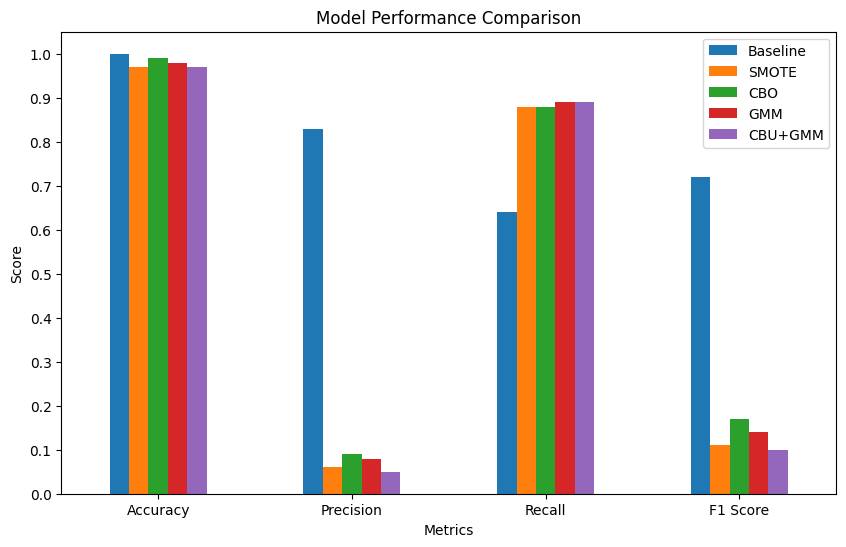

In [55]:
df_results.plot(kind='bar', figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Metrics")
plt.yticks([i/10 for i in range(11)])
plt.xticks(rotation=0)
plt.show()

### 3. Final Recommendation

#### Which method performed the best?

- For **credit card** fraud the most important metric isnt accuracy its **recall**.

    - It is acceptable if we flagged a **non-fraud** transaction to **fraud** (not everytime) 

    - But we must avoid flagging a fraud transaction as non-fraud since that leads to financial loss.

- Therefore, we care about catching as many fraud cases as possible. So recall should be high

- In the **baseline** model although accuracy is `high` recall is `low` risk of not identifying a fradulent transaction

- However **GMM**,**GMM+CBU** have maximum recall followed by **CBO and SMOTE**. 

- Between these, GMM stands out:
    - It has **high recall** like  and GMM+CBU.
    
    - But unlike them, it also achieves **better precision**, meaning it is better at identifying which transactions are actually fraud.

- **Conclusion:** Overall **GMM** is a best resampling strategy that the company should adopt as it balances high recall with relatively stronger precision compared to other techniques